In [90]:
import numpy as np # linear algebra
import pandas as pd # data processing
import datetime as dt # processing dates

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats

import plotly.express as px # charts plotting
import plotly.graph_objects as go # more customized plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [91]:
retail = pd.read_excel('online_retail_II.xlsx')

In [92]:
#Checking and Preparing the Data
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [93]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [94]:
retail['InvoiceDate_DT'] = pd.to_datetime(retail['InvoiceDate'])
retail = retail[retail['Customer ID'].notna()]
retail['Customer ID'] = retail['Customer ID'].astype(np.int64)
retail = retail.sort_values('InvoiceDate_DT')
retail['Total'] = abs(retail['Quantity']) * retail['Price']

In [95]:
#General Sales Analytics
most_expensive = retail.loc[retail['Price'] == retail['Price'].max()]
most_expensive

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceDate_DT,Total
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399,United Kingdom,2010-06-17 16:52:00,25111.09


In [96]:
least_expensive = retail.loc[retail['Price'] == retail['Price'].min()]
least_expensive = least_expensive.groupby(['Description', 'Price'], as_index=False)['Quantity'].agg('sum')
least_expensive

,Description,Price,Quantity
0,FLAMINGO LIGHTS,0.0,24
1,6 RIBBONS EMPIRE,0.0,12
2,AIRLINE BAG VINTAGE JET SET WHITE,0.0,1
3,ANTIQUE GLASS HEART DECORATION,0.0,12
4,ANTIQUE LILY FAIRY LIGHTS,0.0,8
5,BREAD BIN DINER STYLE RED,0.0,1
6,CAKE STAND LACE WHITE,0.0,2
7,CAST IRON HOOK GARDEN FORK,0.0,8
8,CAST IRON HOOK GARDEN TROWEL,0.0,8
9,"CHARLOTTE BAG , SUKI DESIGN",0.0,10


In [97]:
retail_non_zero_price = retail.loc[retail['Price'] != 0]
least_expensive_not_null = retail_non_zero_price.loc[retail_non_zero_price['Price'] == retail_non_zero_price['Price'].min()]
least_expensive_not_null = least_expensive_not_null.groupby(['Description', 'Price'], as_index=False)['Quantity'].agg('sum')
least_expensive_not_null

,Description,Price,Quantity
0,PADS TO MATCH ALL CUSHIONS,0.001,14


In [98]:
#Customers Analysis: Total Purchase Amount
retail_customers = retail.groupby(['Customer ID', 'Country'], as_index=False)['Total'].agg('sum')
retail_customers_asc = retail_customers.sort_values('Total').head(10)
retail_customers_desc = retail_customers.sort_values('Total', ascending=False).head(10)

In [99]:
retail_customers_asc

,Customer ID,Country,Total
1258,14103,United Kingdom,0.00
1806,14827,United Kingdom,0.00
3409,16995,United Kingdom,1.25
1254,14095,United Kingdom,2.95
1036,13788,United Kingdom,3.75
3111,16580,United Kingdom,5.00
1877,14914,United Kingdom,5.85
2598,15913,United Kingdom,6.30
3912,17641,United Kingdom,6.95
1974,15040,United Kingdom,7.49


In [100]:
fig = go.Figure(data=[
    go.Bar(name='Customers With Max Total Purchase Amount', 
           x=retail_customers_desc['Customer ID'].astype(str), 
           y=retail_customers_desc['Total'],
           marker_opacity=1,
           hovertext=retail_customers_desc['Country'],
           marker={'color': retail_customers_desc['Total'], 'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='£%{y:.3s}', textposition='inside')

fig.update_layout(title='Customers With Max Total Purchase Amount',
                  title_x=0.45,
                  xaxis_title="Customer ID",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

In [101]:
fig = go.Figure(data=[
    go.Bar(name='Customers With Min Total Purchase Amount', 
           x=retail_customers_asc['Customer ID'].astype(str), 
           y=retail_customers_asc['Total'],
           marker_opacity=1,
           hovertext=retail_customers_desc['Country'],
           marker={'color': retail_customers_desc['Total'], 'colorscale': 'Rainbow'}
          )
    ])
fig.update_xaxes(side="top")

fig.update_traces(texttemplate='£%{y:.3s}', textposition='inside')

fig.update_layout(title='Customers With Min Total Purchase Amount',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Customer ID",
                  yaxis_title="Total Amount Returned, £",
                  plot_bgcolor='white')
fig.show()

In [102]:
#Countries Analysis: Total Purchase Amount
retail_countries_purchase = retail.groupby(['Country'], as_index=False)['Total'].agg('sum')
retail_countries_purchase_asc = retail_countries_purchase.sort_values('Total').head(10)
retail_countries_purchase_desc = retail_countries_purchase.sort_values('Total', ascending=False).head(10)

In [103]:
fig = go.Figure(data=[
    go.Bar(name='Countries With Max Total Purchase Amount', 
           x=retail_countries_purchase_desc['Country'].astype(str), 
           y=retail_countries_purchase_desc['Total'],
           marker_opacity=1,
           marker={'color': retail_countries_purchase_desc['Total'],'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='£%{y:.3s}', textposition='outside')

fig.update_layout(title='Countries With Max Total Purchase Sum',
                  title_x=0.45,
                  xaxis_title="Countries",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

In [104]:
fig = go.Figure(data=[
    go.Bar(name='Countries With Min Total Purchase Amount', 
           x=retail_countries_purchase_asc['Country'].astype(str), 
           y=retail_countries_purchase_asc['Total'],
           marker_opacity=1,
           marker={'color': retail_countries_purchase_desc['Total'],'colorscale': 'Rainbow'}
          )
    ])

fig.update_traces(texttemplate='£%{y:.3s}', textposition='inside')

fig.update_layout(title='Countries With Min Total Purchase Amount',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Countries",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

In [105]:
#Countries Analysis: Unique Customers Number
retail_countries_customers = retail.groupby(['Country'], as_index=False)['Customer ID'].agg(['nunique']).reset_index()
retail_countries_customers.rename(columns={'nunique': 'Customer Count'}, inplace=True)
retail_countries_customers_asc = retail_countries_customers.sort_values('Customer Count').head(10)
retail_countries_customers_desc = retail_countries_customers.sort_values('Customer Count', ascending=False).head(10)

In [106]:
fig = go.Figure(data=[
    go.Bar(name='Countries with Largest Number of Unique Customers', 
           x=retail_countries_customers_desc['Country'].astype(str), 
           y=retail_countries_customers_desc['Customer Count'],
           marker_opacity=1,
           marker={'color': retail_countries_customers_desc['Customer Count'],'colorscale': 'Rainbow'})
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')

fig.update_layout(title='Countries with Largest Number of Unique Customers',
                  title_x=0.45,
                  xaxis_title="Countries",
                  yaxis_title="Number of Unique Customers",
                  plot_bgcolor='white')
fig.show()


fig = go.Figure(data=[
    go.Bar(name='Countries with Smallest Number of Unique Customers', 
           x=retail_countries_customers_asc['Country'].astype(str), 
           y=retail_countries_customers_asc['Customer Count'],
           marker_opacity=1,
           marker={'color': retail_countries_customers_desc['Customer Count'],'colorscale': 'Rainbow'}
          )
    ])

fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')

fig.update_layout(title='Countries with Smallest Number of Unique Customers',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Countries",
                  yaxis_title="Number of Unique Customers",
                  plot_bgcolor='white')
fig.show()

In [107]:
#Online Sales on Timeline
retail = retail[retail['InvoiceDate_DT'].dt.year != 2009]
retail['InvoiceQuarter'] = ('Q' + retail['InvoiceDate_DT'].dt.quarter.astype(str) + 
                            '/' + retail['InvoiceDate_DT'].dt.year.astype(str))
quarters_map = dict(zip(retail['InvoiceQuarter'].unique(), 
                        range(len(retail['InvoiceQuarter'].unique()))))
retail['InvoiceQuarterID'] = retail['InvoiceQuarter'].map(quarters_map)

retail_quarters_by_sales = retail.groupby(['InvoiceQuarterID'], as_index=False)['Total'].agg('sum')
retail_quarters_by_sales['InvoiceQuarter'] = retail_quarters_by_sales['InvoiceQuarterID'].map(dict(zip(quarters_map.values(), 
                                                                                                               quarters_map.keys())))

In [108]:
fig = go.Figure(data=[
    go.Bar(name='Quarterly Sales', 
           x=retail_quarters_by_sales['InvoiceQuarter'],
           y=retail_quarters_by_sales['Total'],
           marker_opacity=1,
           text='Total',
           marker={'color': retail_quarters_by_sales['Total'],
                   'colorscale': 'Portland'}
          )
    ])

fig.update_traces(texttemplate='%{text}: £%{y:.3s}', textposition='outside')
fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title="Quarterly Sales",
                  title_x = 0.45,
                  xaxis_title="Quarters",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()

In [109]:
#Preprocessing data
retail['Invoice'] = retail['Invoice'].astype(str)
retail_df = retail[~retail['Invoice'].str.contains('C')]

In [110]:
retail_df = retail_df[retail_df['Price']>0]
retail_df.shape

(376910, 12)

In [111]:
retail_df[retail_df.duplicated()].shape

(6266, 12)

In [112]:
retail_df = retail_df.drop_duplicates(keep='first')

In [113]:
print((retail_df.Quantity<0).sum())
print((retail_df.Price<0).sum())

0
0


In [114]:
#Clustering
retail_df["InvoiceDate_DT"].max()

Timestamp('2010-12-09 20:01:00')

In [115]:
today_date = dt.datetime(2011,12,11)

In [116]:
# Create RFM dataframe.
retail_rfm = retail_df.groupby("Customer ID").agg({"InvoiceDate_DT" : lambda InvoiceDate_DT: (today_date - InvoiceDate_DT.max()).days, # Recency
                                "Invoice" : lambda Invoice : Invoice.nunique(), # Frequency
                                "Total" : lambda Total: Total.sum()}) # Monetary

In [117]:
retail_rfm.head()

,InvoiceDate_DT,Invoice,Total
Customer ID,,,
12346,530,6,259.36
12347,368,2,1323.32
12348,439,1,222.16
12349,408,3,2671.14
12351,376,1,300.93


In [118]:
# Change the column name.
retail_rfm.columns = ["Recency", "Frequency", "Monetary"]
retail_rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,530,6,259.36
12347,368,2,1323.32
12348,439,1,222.16
12349,408,3,2671.14
12351,376,1,300.93


<Axes: xlabel='Monetary', ylabel='# of occurences'>

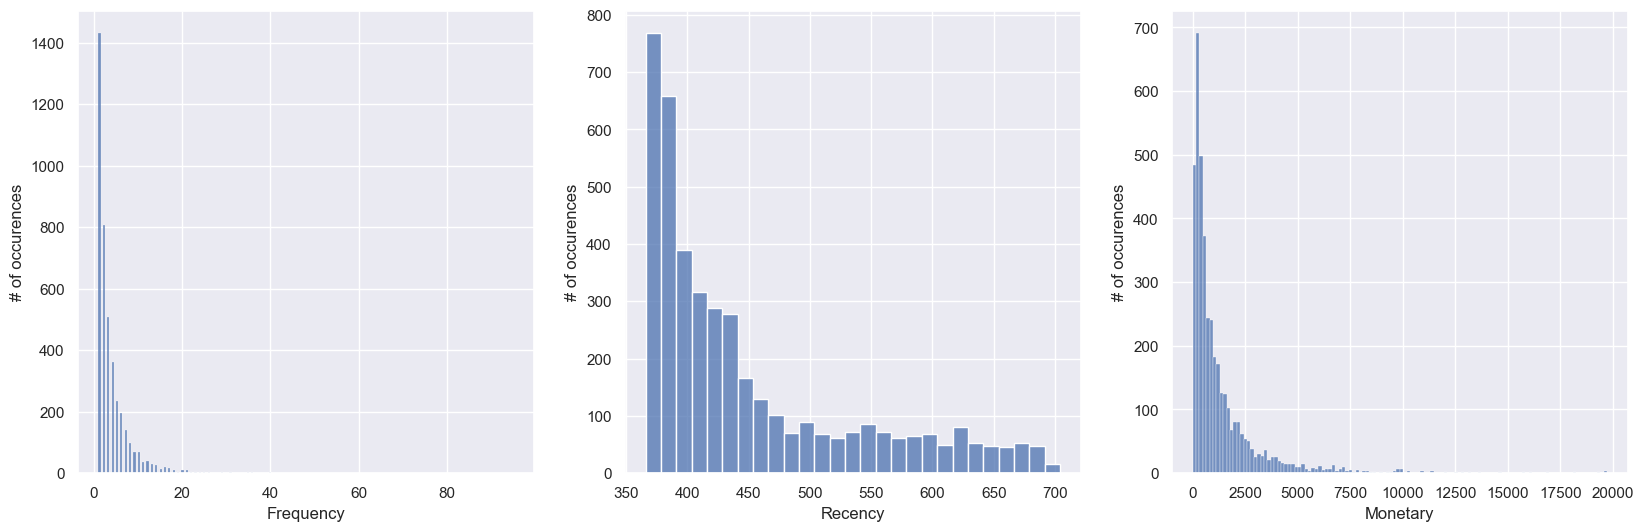

In [119]:
# Plot the distributions of the three quantities.
f, ax = plt.subplots(1, 3, figsize=(20, 6))
for a in ax:
    a.set_ylabel("# of occurences")
sns.histplot(retail_rfm.query("Frequency < 100")["Frequency"], kde=False, ax=ax[0])
sns.histplot(retail_rfm["Recency"], kde=False, ax=ax[1])
sns.histplot(retail_rfm.query("Monetary < 20000")["Monetary"], kde=False, ax=ax[2])

In [120]:
rfm_unskewed = np.array([stats.boxcox(retail_rfm[["Frequency", "Recency", "Monetary"]].values[:,i])[0] for i in range(3)]).T

scaler = StandardScaler()
scaler.fit(rfm_unskewed)
rfm_scaled = pd.DataFrame(scaler.transform(rfm_unskewed), columns=["frequency", "recency", "monetary"])

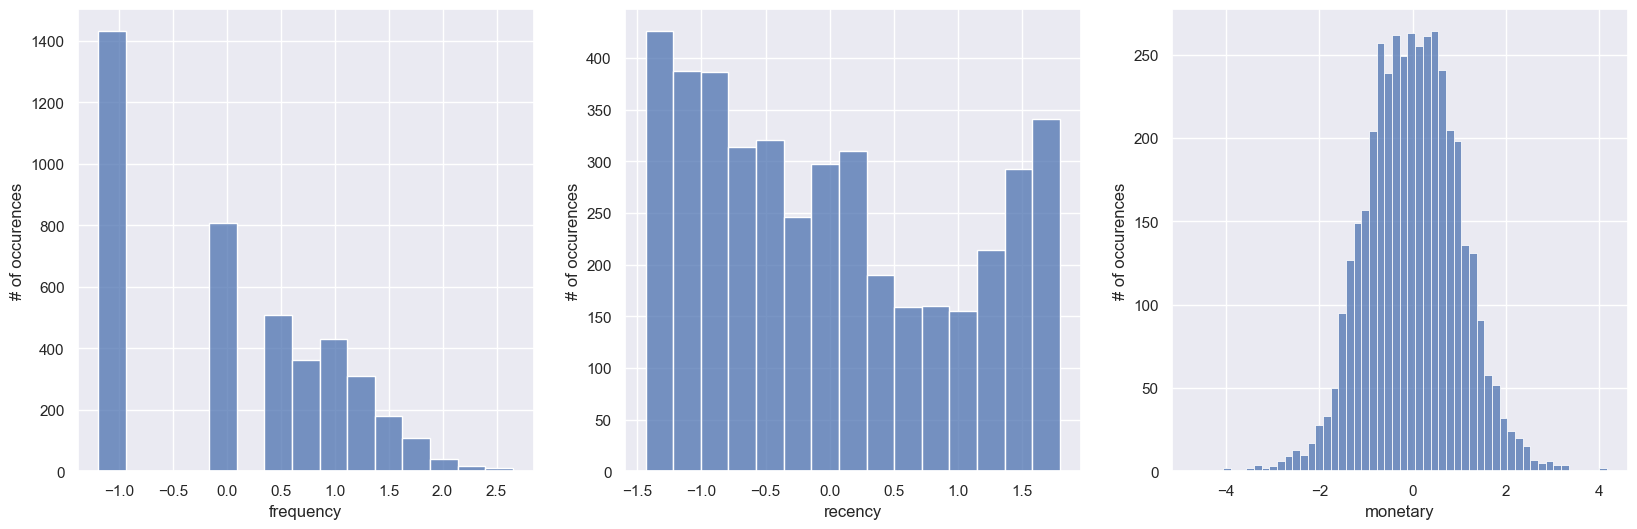

In [121]:
def plot_dist_scaled(rfms=rfm_scaled):
    f, ax = plt.subplots(1, 3, figsize=(20, 6))
    for i, a in enumerate(ax):
        a.set_ylabel("# of occurences")
        col = rfms.columns[i]
        sns.histplot(rfms[col], kde=False, ax=a)
        a.set_xlabel(col)
plot_dist_scaled()

In [122]:
inertias = []
silhouettes = []
calinski = []
davies = []
n_clusters = np.arange(2, 10, 1)

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_scaled, kmeans.predict(rfm_scaled)))
    calinski.append(calinski_harabasz_score(rfm_scaled, kmeans.predict(rfm_scaled)))
    davies.append(davies_bouldin_score(rfm_scaled, kmeans.predict(rfm_scaled)))

Text(0, 0.5, 'Inertia score')

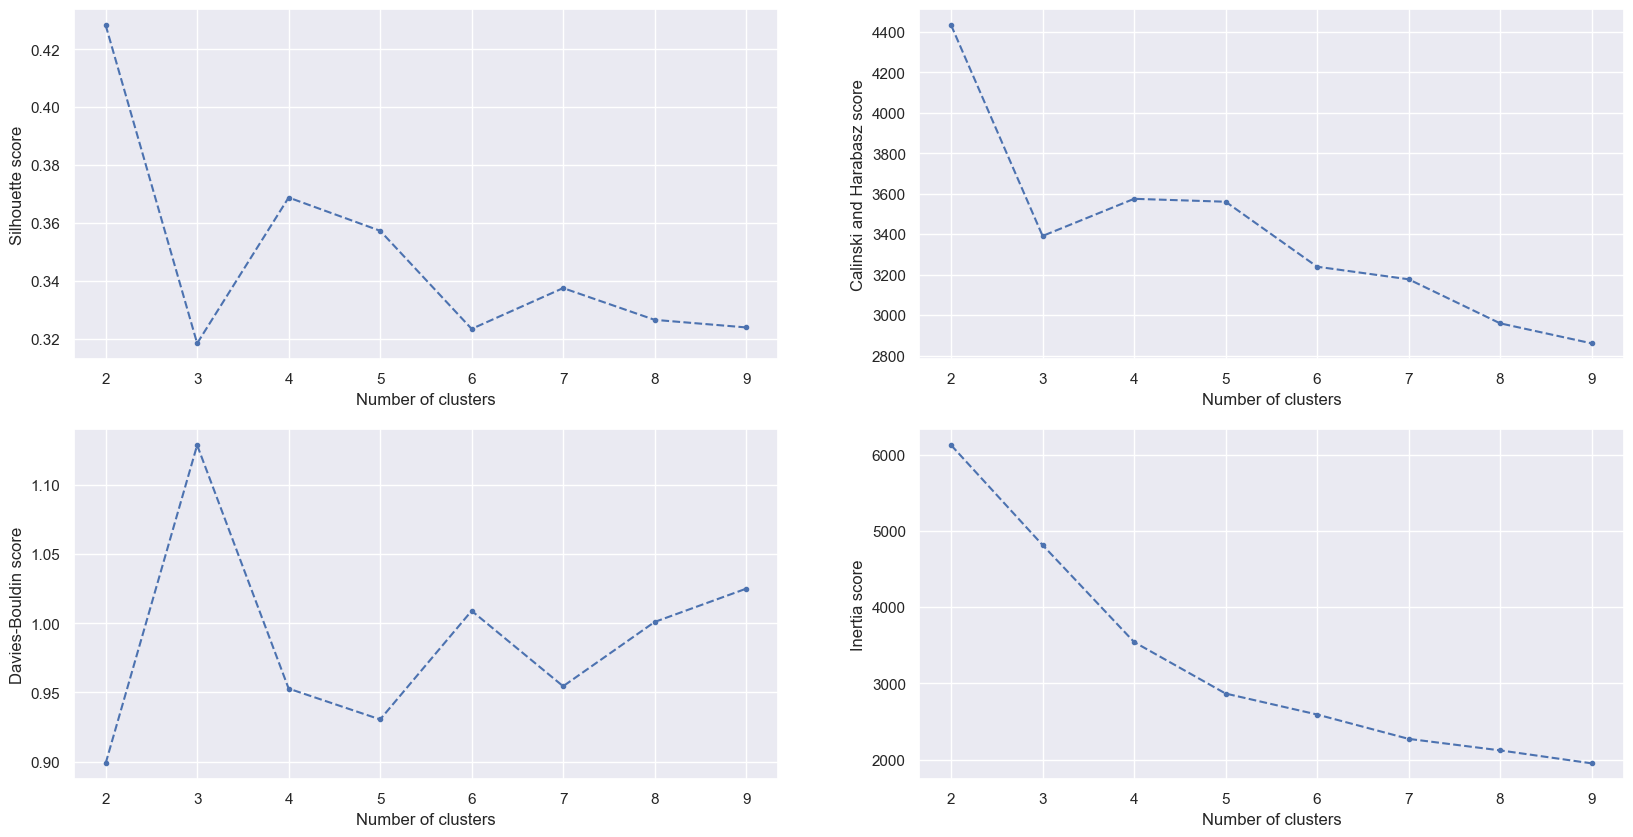

In [123]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))
for a in ax.flatten():
    a.set_xlabel("Number of clusters")

ax[0, 0].plot(n_clusters, silhouettes, ".--")
ax[0, 0].set_ylabel("Silhouette score")

ax[0, 1].plot(n_clusters, calinski, ".--")
ax[0, 1].set_ylabel("Calinski and Harabasz score")

ax[1, 0].plot(n_clusters, davies, ".--")
ax[1, 0].set_ylabel("Davies-Bouldin score")

ax[1, 1].plot(n_clusters, inertias, ".--")
ax[1, 1].set_ylabel("Inertia score")

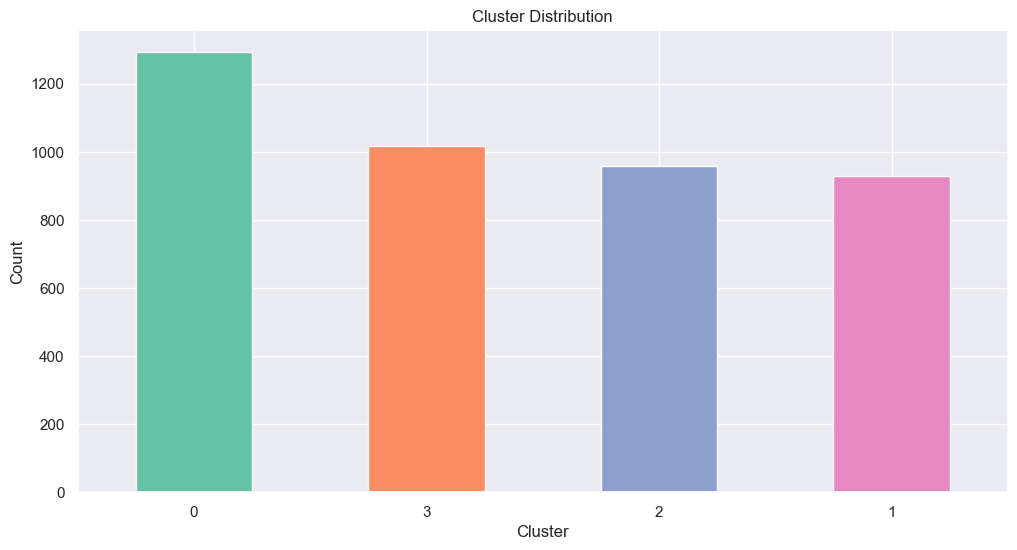

In [124]:
nclusters=4
kmeans = KMeans(n_clusters=nclusters, random_state=13)
kmeans.fit(rfm_scaled)

retail_rfm["Cluster"] = kmeans.predict(rfm_scaled)
# Use the 'value_counts()' function to count the occurrences of each cluster
cluster_counts = retail_rfm['Cluster'].value_counts()

# Define a color palette with different colors for each cluster
# You can customize the colors as needed
colors = sns.color_palette("Set2")

# Plot the bar chart with customized colors
plt.figure(figsize=(12, 6))
ax = cluster_counts.plot(kind='bar', color=colors)
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Adjust the rotation angle of the x-labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Display the plot
plt.show()

In [125]:
retail_rfm.groupby("Cluster").mean()

,Recency,Frequency,Monetary
Cluster,,,
0,383.418407,9.214230,4728.687075
1,570.945102,1.122713,278.245944
2,471.253125,3.369792,1372.858473
3,399.073746,1.483776,417.013500


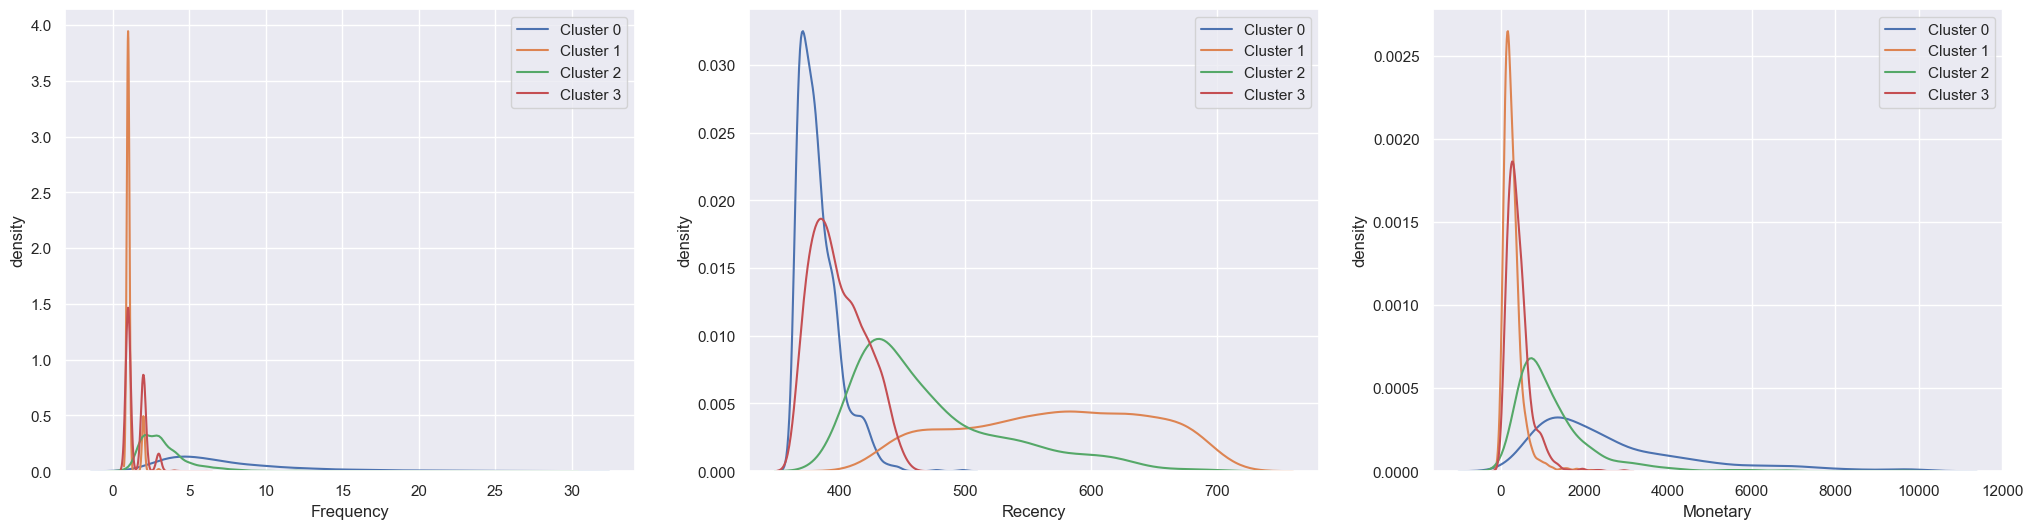

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, 3, figsize=(25, 6))

for a in ax:
    a.set_ylabel("density")

for c in range(nclusters):
    rfm_c = retail_rfm.query(f"Cluster == {c}")
    label = f"Cluster {c}"

    sns.kdeplot(rfm_c.query("Frequency < 30")["Frequency"], ax=ax[0], label=label)
    sns.kdeplot(rfm_c["Recency"], ax=ax[1], label=label)
    sns.kdeplot(rfm_c.query("Monetary < 10000")["Monetary"], ax=ax[2], label=label)
    
for a in ax:
    a.legend()

plt.show()

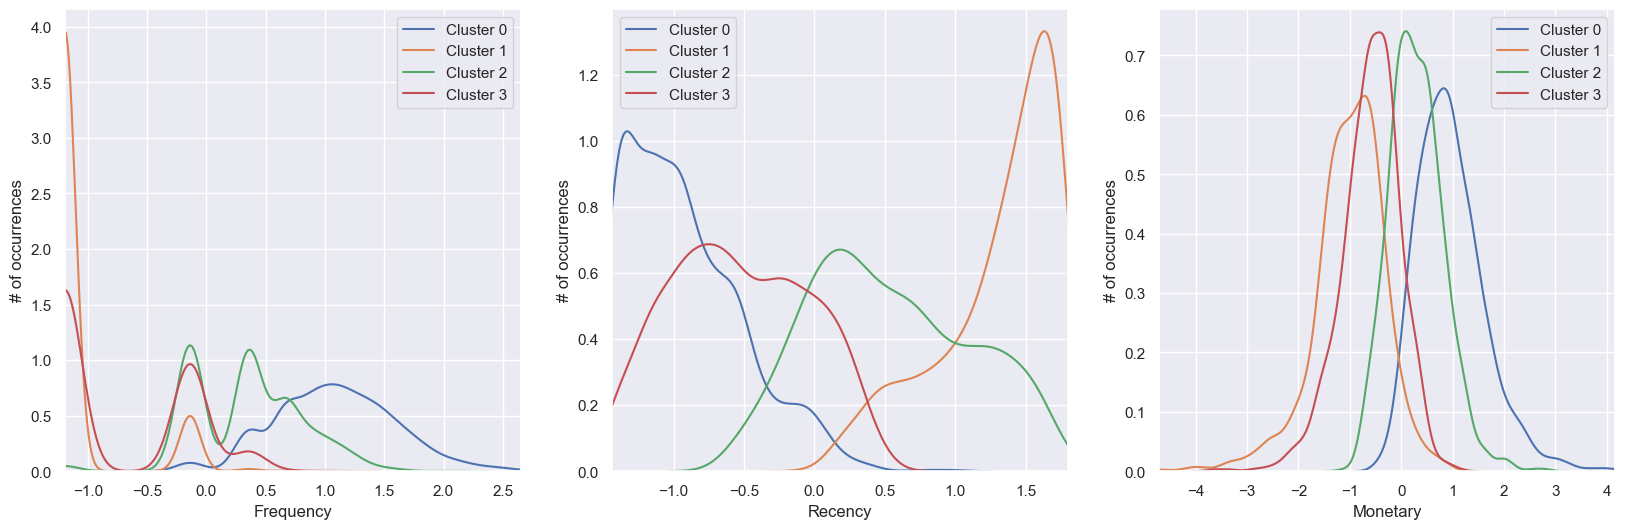

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming retail_rfm, scaler, and nclusters are defined elsewhere in your code

def plot_dist_transformed_cluster(transformation=lambda x: x, columns=["Frequency", "Recency", "Monetary"]):

    f, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    bins = 30
    
    ranges = {}
    
    rfm_ = pd.DataFrame(scaler.transform(transformation(retail_rfm[columns])), columns=columns)
    rfm_["Cluster"] = retail_rfm["Cluster"].values
    
    for i, a in enumerate(ax):
        a.set_ylabel("# of occurrences")
        col = rfm_.columns[i]
        x_min, y_min = min(rfm_[col]), max(rfm_[col])
        ranges[col] = (x_min, y_min)
        a.set_xlim(x_min, y_min)
        a.set_xlabel(col)
        
    for c in range(nclusters):
        rfm_c = rfm_.query(f"Cluster == {c}")
        label = f"Cluster {c}"
    
        for i, a in enumerate(ax):
            col = rfm_c.columns[i]
            toplot = rfm_c[col]
            sns.kdeplot(toplot, ax=a, label=label)
            a.legend()
        
plot_dist_transformed_cluster(lambda x: np.array([stats.boxcox(x.values[:,i])[0] for i in range(3)]).T)

In [128]:
#Train Forecast models
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370644 entries, 45228 to 525460
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Invoice           370644 non-null  object        
 1   StockCode         370644 non-null  object        
 2   Description       370644 non-null  object        
 3   Quantity          370644 non-null  int64         
 4   InvoiceDate       370644 non-null  datetime64[ns]
 5   Price             370644 non-null  float64       
 6   Customer ID       370644 non-null  int64         
 7   Country           370644 non-null  object        
 8   InvoiceDate_DT    370644 non-null  datetime64[ns]
 9   Total             370644 non-null  float64       
 10  InvoiceQuarter    370644 non-null  object        
 11  InvoiceQuarterID  370644 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 36.8+ MB


In [129]:
retail_df1 = retail_df.drop(['StockCode','Description','Country','InvoiceDate', 'InvoiceQuarter', 'InvoiceQuarterID'], axis=1)
# Extract the date part from InvoiceDate_DT column
retail_df1['InvoiceDate_DT'] = retail_df['InvoiceDate_DT'].dt.date
retail_df1['InvoiceDate_DT'] = pd.to_datetime(retail_df1['InvoiceDate_DT'])
# Resetting index for retail_rfm
retail_rfm_reset = retail_rfm.reset_index()
# Merging only the Cluster columns
merged_df = pd.merge(retail_df1, retail_rfm_reset[['Customer ID', 'Cluster']], on='Customer ID', how='inner')
# Creating Daily Sales DataFrames for Each Cluster
grouped = merged_df.groupby(['InvoiceDate_DT', 'Cluster']).Total.sum().reset_index()
clusters = grouped['Cluster'].unique()
daily_sales_dfs = {cluster: grouped[grouped['Cluster'] == cluster].set_index('InvoiceDate_DT').drop(columns='Cluster') for cluster in clusters}

# Splitting into Train and Test Sets

train_dfs = {}
test_dfs = {}
test_size = 0.2
for cluster, df in daily_sales_dfs.items():
    split_idx = int(len(df) * (1 - test_size))
    train_dfs[cluster] = df[:split_idx]
    test_dfs[cluster] = df[split_idx:]

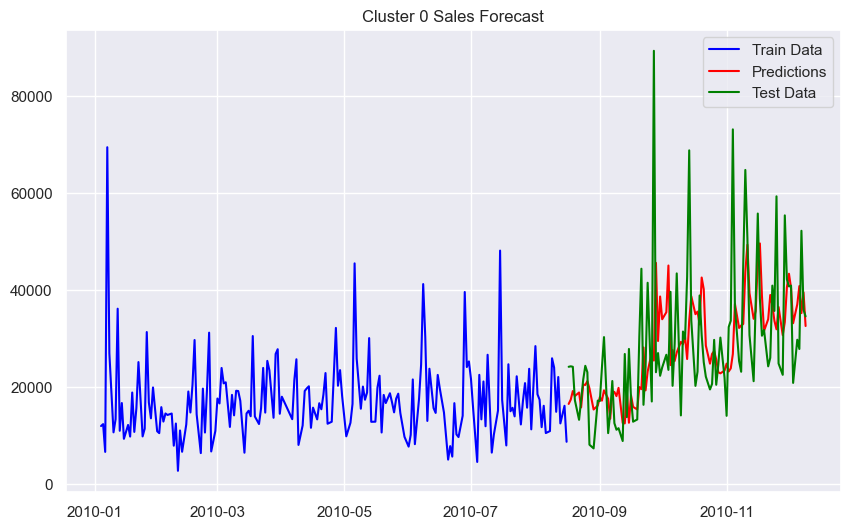

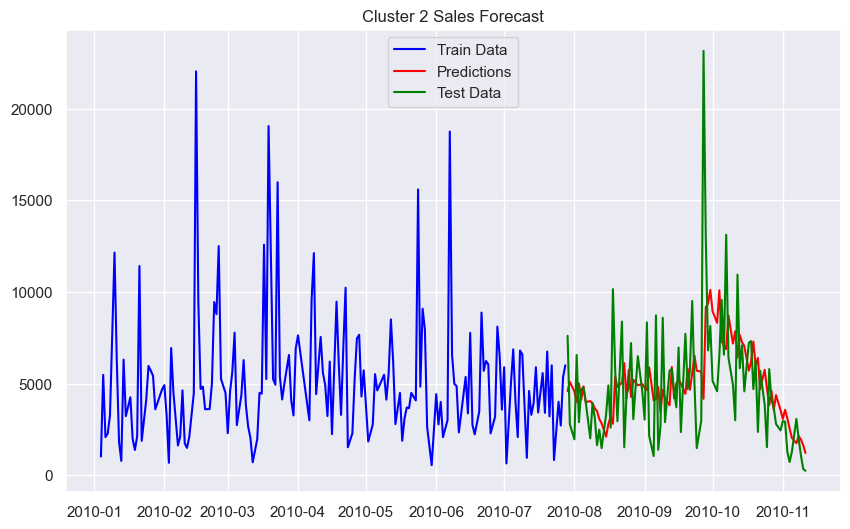

c:\Users\Akash2m\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



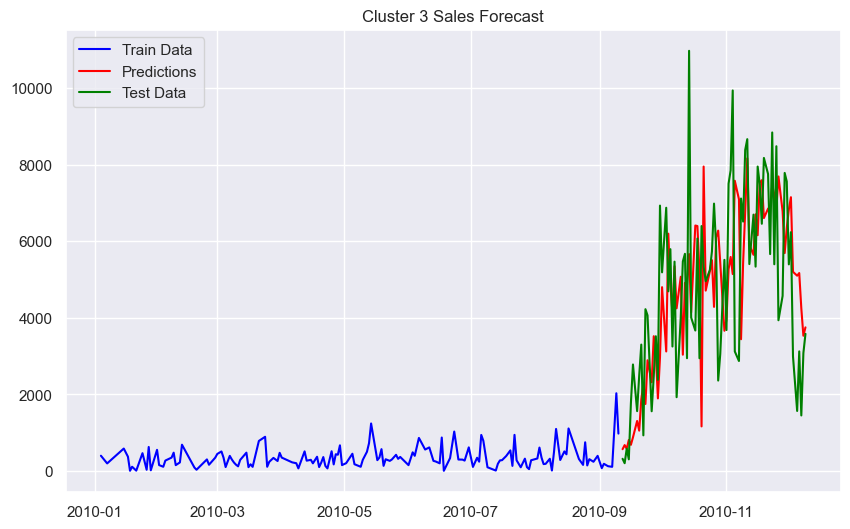

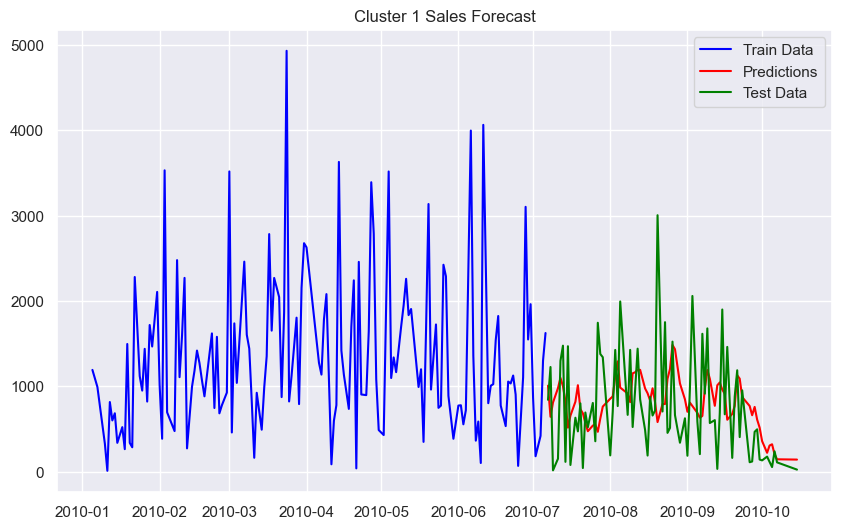

   Cluster           MSE
0        0  1.791419e+08
1        2  1.013527e+07
2        3  4.479664e+06
3        1  3.631622e+05


In [130]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

mse_values = {}

for cluster in clusters:
    # Combine train and test data
    data = pd.concat([train_dfs[cluster]['Total'], test_dfs[cluster]['Total']])
    size = int(len(data) * 0.66)
    train, test = data.iloc[0:size], data.iloc[size:len(data)]
    history = list(train)
    predictions = []
    
    # Rolling-forecast
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test.iloc[t]
        history.append(obs)
    
    mse = mean_squared_error(test, predictions)
    mse_values[cluster] = mse
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot the train data
    plt.plot(train.index, train.values, label='Train Data', color='blue')
    
    # Adjust the index for predictions to align with the test data index
    prediction_index = test.index
    plt.plot(prediction_index, predictions, color='red', label='Predictions')
    
    # Plot the test data
    plt.plot(test.index, test.values, label='Test Data', color='green')
    
    plt.title(f'Cluster {cluster} Sales Forecast')
    plt.legend()
    plt.show()

# Convert the MSE values to a DataFrame and display
mse_df = pd.DataFrame(list(mse_values.items()), columns=['Cluster', 'MSE'])
print(mse_df)

In [131]:
#Monthly Sales
retail_monthly = retail.copy()
retail_monthly['InvoiceMonth'] = retail_monthly['InvoiceDate_DT'].dt.to_period('M')
retail_monthly_by_sales = retail_monthly.groupby(['InvoiceMonth'], as_index=False)['Total'].agg('sum')

In [132]:
fig = go.Figure(data=[
    go.Bar(name='Monthly Sales', 
           x=retail_monthly_by_sales['InvoiceMonth'].astype(str),
           y=retail_monthly_by_sales['Total'],
           marker_opacity=1,
           marker={'color': retail_monthly_by_sales['Total'],'colorscale': 'Portland'}
          )
    ])

fig.update_layout(barmode='group', showlegend=False)

fig.update_layout(title="Monthly Sales",
                  title_x = 0.45,
                  xaxis_title="Months",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor='white')
fig.show()